In [24]:
import os
os.chdir('/nfs/homedirs/rachwan/Evaluation-Tool')

# ResNet18

In [25]:
import copy

from utils.model_utils import *
from torch.optim.lr_scheduler import OneCycleLR
from utils.constants import TRAINERS_DIR, DATASET_PATH
from models.networks.ResNet18 import ResNet18
from models.losses.CrossEntropy import CrossEntropy

from models.metrics.Evaluator import Evaluator

In [26]:
model = ResNet18().cuda()

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=5e-5)

In [29]:
# Get Data

transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.Resize(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = datasets.CIFAR10(DATASET_PATH, train=True, transform=transform_train, download=True)

test_set = datasets.CIFAR10(root=DATASET_PATH, train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=128,
        shuffle=True,
        pin_memory=True,
        num_workers=10
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=10
)

Files already downloaded and verified
Files already downloaded and verified


/nfs/homedirs/rachwan/miniconda3/envs/structure_pruning/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
scheduler = OneCycleLR(optimizer, max_lr=2e-3,
                                 steps_per_epoch=len(train_loader), epochs=1)

In [31]:
loss = CrossEntropy()

In [32]:
trainer = find_right_model(
            TRAINERS_DIR, 'SimpleTrainer',
            model=model,
            loss=loss,
            optimizer=optimizer,
            device='cuda',
            epochs=1,
            train_loader=train_loader,
            test_loader=test_loader,
            scheduler=scheduler,
        )

In [33]:
# Load evaluatior
evaluator = Evaluator()

In [34]:
# Evaluate model
evaluator.evaluate_full_training(trainer, model)



EPOCH 0  






/nfs/homedirs/rachwan/miniconda3/envs/structure_pruning/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training... 390/391

Evaluating... 78/79

Test Accuracy: 0.6316257911392406


In [35]:
r18metrics = copy.deepcopy(evaluator.get_all_metrics())
r18metrics

{'time': 20588.53515625,
 'gpu': 0.838925824,
 'disk': 99.3140145,
 'cost': 0.82,
 'emission': 0.9242580836626553,
 'energy': 3.0706248626666293}

# ResNet50

In [37]:
from models.networks.ResNet50 import ResNet50

model = ResNet50().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=5e-5)

scheduler = OneCycleLR(optimizer, max_lr=2e-3,
                                 steps_per_epoch=len(train_loader), epochs=1)

loss = CrossEntropy()

trainer = find_right_model(
            TRAINERS_DIR, 'SimpleTrainer',
            model=model,
            loss=loss,
            optimizer=optimizer,
            device='cuda',
            epochs=1,
            train_loader=train_loader,
            test_loader=test_loader,
            scheduler=scheduler,
        )

In [38]:
# Load evaluatior
evaluator = Evaluator()

# Evaluate model
evaluator.evaluate_full_training(trainer, model)

r50metrics = copy.deepcopy(evaluator.get_all_metrics())
r50metrics



EPOCH 0  






/nfs/homedirs/rachwan/miniconda3/envs/structure_pruning/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training... 390/391

Evaluating... 78/79

Test Accuracy: 0.5279865506329114


{'time': 27887.11328125,
 'gpu': 1.989208064,
 'disk': 207.8178725,
 'cost': 0.82,
 'emission': 1.305582754948599,
 'energy': 4.337484235709631}

# Compare Models

In [39]:
import matplotlib.pyplot as plt
import numpy as np

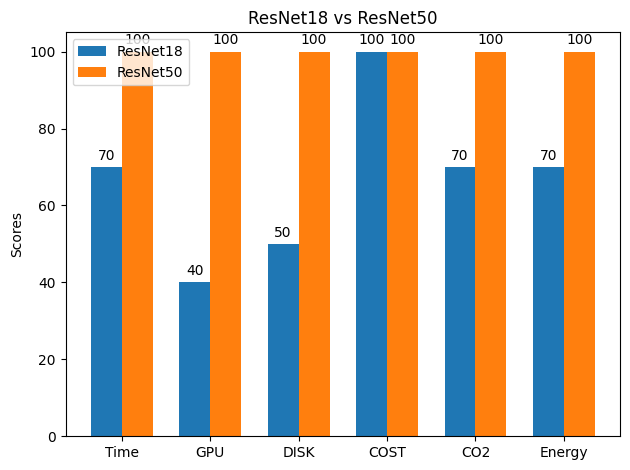

In [41]:
labels = ['Time', 'GPU', 'DISK', 'COST', 'CO2', 'Energy']
r18_means = [round(r18/r50,1) * 100 for r18, r50 in zip(r18metrics.values(), r50metrics.values())]
r50_means = [100 for v in r50metrics.values()]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, r18_means, width, label='ResNet18')
rects2 = ax.bar(x + width/2, r50_means, width, label='ResNet50')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ResNet18 vs ResNet50')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()